# Imports 

In [82]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from mpl_toolkits import mplot3d
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Load Data

In [83]:
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])

# include a variable which tells if a grid is in socat location
# so that we can split a test set during the model training
merged_dataset = xr.merge([merged_dataset, ds['pCO2']['socat_mask']])

df = merged_dataset.to_dataframe().reset_index()

df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)

X = np.array(df[['xlon', 'ylat', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl']])

Y = np.array(df[['pCO2']])

In [84]:
SOM_input = df[['xlon', 'ylat', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl']]
means = SOM_input.groupby(['ylat','xlon'], as_index=False).mean()

# DBSCAN Clustering 

## Deciding Parameters

In [85]:
means1 = np.array(means)

In [81]:
distance_matrix = euclidean_distances(means1, means1)

(41070, 7)

In [107]:
distance_matrix

array([[  0.        ,   1.17145901,   3.70012796, ..., 316.73012748,
        316.74832044, 316.83778472],
       [  0.        ,   1.17145901,   2.69565575, ..., 316.86047433,
        316.8775127 , 316.97138617],
       [  0.        ,   2.69565575,   3.70012796, ..., 315.6556757 ,
        315.6681381 , 315.77080361],
       ...,
       [  0.        ,   1.00003722,   1.00003742, ..., 426.14712286,
        431.52229747, 432.14567586],
       [  0.        ,   1.00003742,   1.00003759, ..., 426.27885667,
        431.65712803, 432.27801367],
       [  0.        ,   1.00003759,   1.1866523 , ..., 426.41291403,
        431.79425148, 432.41264268]])

In [ ]:
distance_matrix.sort(axis=1)

In [129]:
distance_matrix1=distance_matrix[:,1:11]
pm=distance_matrix1.flatten()
pm=np.sort(pm)
pm = pm[::-1]

Text(0,0.5,'K-Distances')

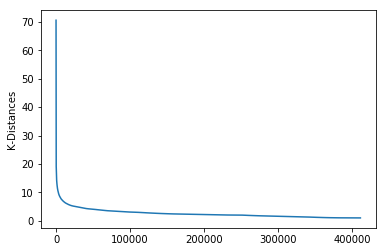

In [132]:
plt.plot(pm)
plt.ylabel('K-Distances')

We make a K-distance plot of the data. This plot helps us determine the density of the data and thus give us an idea of what the value of epsilon. The min points are also hard to decide but its a universally acceptable heurestic to use Log(n) as the number K where n is the total number of datapoints. Epsilon is chosen as the distance where the curve flattens out.

## Clustering

In [135]:
clustering = DBSCAN(eps=10, min_samples=10).fit(means)

In [136]:
len(set(clustering.labels_))

11

In [137]:
labels = pd.DataFrame(clustering.labels_)
labels.columns = ['dbscan']
finaldf = pd.concat([means,labels], axis = 1)
finaldf.columns = ['xlon', 'ylat', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl', 'dbscan_clusters']

In [138]:
finaldf.head()

,xlon,ylat,XCO2,SST,SSS,MLD,Chl,dbscan_clusters
0,-77.5,179.5,370.185059,-1.257135,34.316242,237.387344,0.981023,-1
1,-77.5,180.5,370.185059,-1.274530,34.295708,236.778397,1.008854,-1
2,-77.5,181.5,370.185059,-1.300513,34.269802,234.275604,1.044126,-1
3,-77.5,182.5,370.185059,-1.334906,34.241173,226.481583,1.084508,-1
4,-77.5,183.5,370.185059,-1.375007,34.213009,211.385742,1.126487,-1


In [139]:
finaldf.to_csv('dbscan_clusters.csv')